In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/PA/archive.zip 

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Conv3D, MaxPooling3D,GlobalAveragePooling3D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf 
from tensorflow.keras.preprocessing import image


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/Mini/COVID-19_Radiography_Dataset"

os.listdir(DATASET_DIR)

['COVID.metadata.xlsx',
 'Lung_Opacity.metadata.xlsx',
 'Normal.metadata.xlsx',
 'README.md.txt',
 'Viral Pneumonia.metadata.xlsx',
 'Chest.jpg',
 'covid_pa.h5',
 'Normal.png',
 'Viral Pneumonia',
 'Normal',
 'COVID',
 'Lung_Opacity']

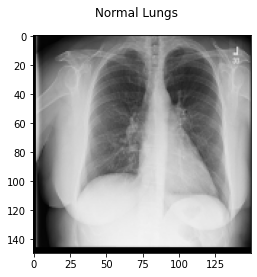

In [ ]:
normal_images = []
count = 0 
for img_path in glob.glob(DATASET_DIR + "/Normal/*"):
  count = count +1
  normal_images.append(image.load_img(str(img_path), target_size = (150,150,3)))
  if count >500:
    break
    
fig = plt.figure()
fig.suptitle("Normal Lungs")
plt.imshow(normal_images[0])
plt.show()

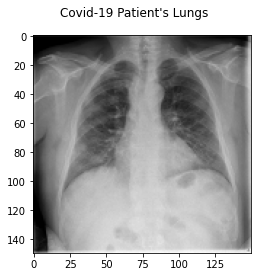

In [ ]:
covid_images = []
count = 0
for img_path in glob.glob(DATASET_DIR + "/COVID/*"): 
    covid_images.append(image.load_img(str(img_path), target_size = (150,150,3)))
    count = count + 1
    if(count > 100):
      break 
fig = plt.figure()
fig.suptitle("Covid-19 Patient's Lungs ")
plt.imshow(covid_images[1])
plt.show()

In [ ]:
print(str(len(normal_images))+" normal patient images")
print(str(len(covid_images))+" covid patient images")

501 normal patient images
101 covid patient images


In [ ]:
images_together = []

for i in normal_images:
    images_together.append(img_to_array(i))
    
for i in covid_images:
    images_together.append(img_to_array(i))
    
targets = np.zeros(len(images_together))
targets[:len(normal_images)-1]=1


In [ ]:
targets = np.array(targets)
print("targets: ",targets.shape)
targets = targets.reshape(-1,1)
print("new shape of targets: ",targets.shape)
images_together = np.array(images_together)

targets:  (602,)
new shape of targets:  (602, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_together, targets, test_size=0.25, stratify=targets)

images_together = np.concatenate((X_train, X_val))
targets = np.concatenate((y_train, y_val))


In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (150,150,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 48, kernel_size = (3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"))

model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

model.add(MaxPool2D(pool_size = (2,2), strides = (1,1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))
 
model.compile(loss = "binary_crossentropy",
             optimizer = "rmsprop",
             metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 48)        13872     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        27712     
_________________________________________________________________
dense (Dense)                (None, 34, 34, 1)         65        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 33, 33, 1)         0

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.25)


train_generator = train_datagen.flow(
images_together, targets,
batch_size = 40,
subset = "training")

validation_generator = train_datagen.flow(
images_together, targets,
batch_size = 40,
shuffle = False,
subset = "validation")


hist = model.fit(train_generator,steps_per_epoch = (450*0.75)//40,validation_data = validation_generator,
validation_steps = (450*0.25)// 40,
epochs = 100)

Epoch 1/100
8/8 [==============================] - 14s 2s/step - loss: 0.5676 - accuracy: 0.7129 - val_loss: 0.4408 - val_accuracy: 0.8500
Epoch 2/100
8/8 [==============================] - 12s 1s/step - loss: 0.4833 - accuracy: 0.8444 - val_loss: 0.4459 - val_accuracy: 0.8500
Epoch 3/100
8/8 [==============================] - 12s 1s/step - loss: 0.4581 - accuracy: 0.8584 - val_loss: 0.4977 - val_accuracy: 0.8500
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 0.5315 - accuracy: 0.8349 - val_loss: 0.4426 - val_accuracy: 0.8500
Epoch 5/100
8/8 [==============================] - 11s 1s/step - loss: 0.4559 - accuracy: 0.8541 - val_loss: 0.4603 - val_accuracy: 0.8500
Epoch 6/100
8/8 [==============================] - 11s 1s/step - loss: 0.4945 - accuracy: 0.8381 - val_loss: 0.4398 - val_accuracy: 0.8500
Epoch 7/100
8/8 [==============================] - 12s 1s/step - loss: 0.4834 - accuracy: 0.8298 - val_loss: 0.4654 - val_accuracy: 0.8500
Epoch 8/100
8/8 [==========

KeyboardInterrupt: ignored

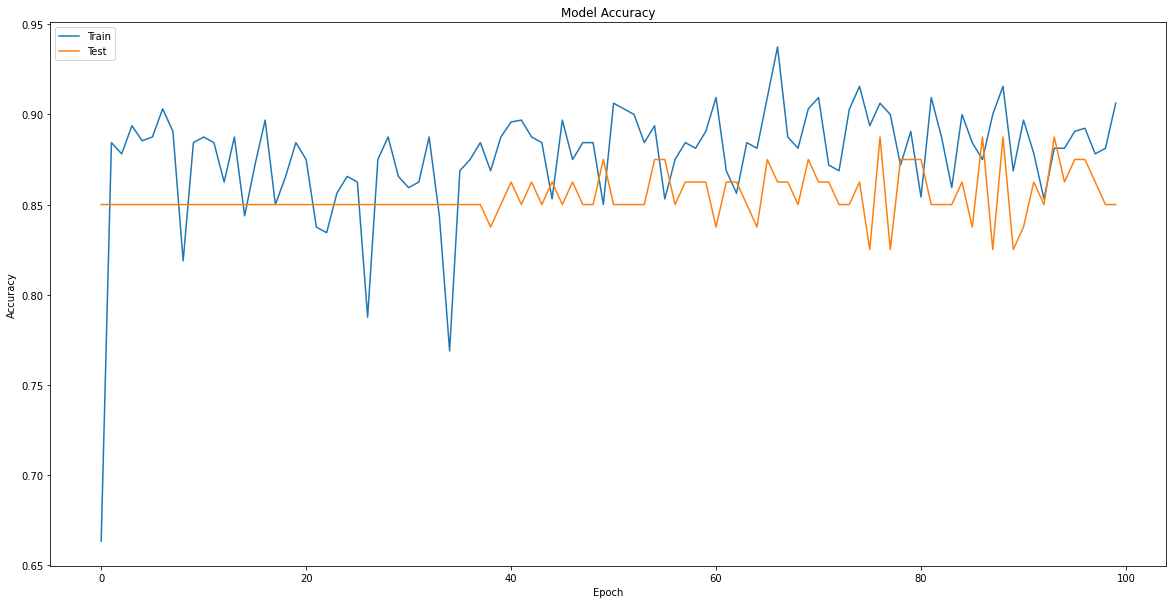

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

In [ ]:
print("Training Accuracy: "+str(np.round(hist.history["accuracy"][-1]*100,2))+"%")

Training Accuracy: 90.62%


In [ ]:
model.save("PA.h5")

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np

In [ ]:
filepath = ("/content/PA.h5")

In [ ]:
model = load_model(filepath, compile = True)

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#Taking I/p from the user

from google.colab import files
a = []
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  a.append(fn)

print(a)

Saving Chest.jpg to Chest.jpg
Saving Covid1.png to Covid1.png
Saving Normal.png to Normal.png
User uploaded file "Chest.jpg" with length 50419 bytes
User uploaded file "Covid1.png" with length 40105 bytes
User uploaded file "Normal.png" with length 29307 bytes
['Chest.jpg', 'Covid1.png', 'Normal.png']


In [ ]:

for i in range(len(a)):
  b = "/content/" + a[i]
  from keras.preprocessing import image
  test_image = image.load_img(b, target_size = (150,150,3)) 
  #test_image = image.load_img(imagePath, target_size = (150,150,3)) 
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)

  result = model.predict(test_image)
  #print(result)
  if(result[0][0]== 0.0):
    print(a[i], "Covid 19 Detected")
  else:
    print(a[i],"Normal, No covid Detected")


Chest.jpg Covid 19 Detected
Covid1.png Covid 19 Detected
Normal.png Normal, No covid Detected
